<a href="https://colab.research.google.com/github/arjunprakash027/HandcraftedML/blob/main/Reinforcement_Learning/trying_things_out/Financial_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Working this out

Understand whats happening

- [Understand LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Perplexity convo about lstm and hidden states](https://www.perplexity.ai/search/https-colah-github-io-posts-20-VOno0xn_Tua8Q99I4rik4w)

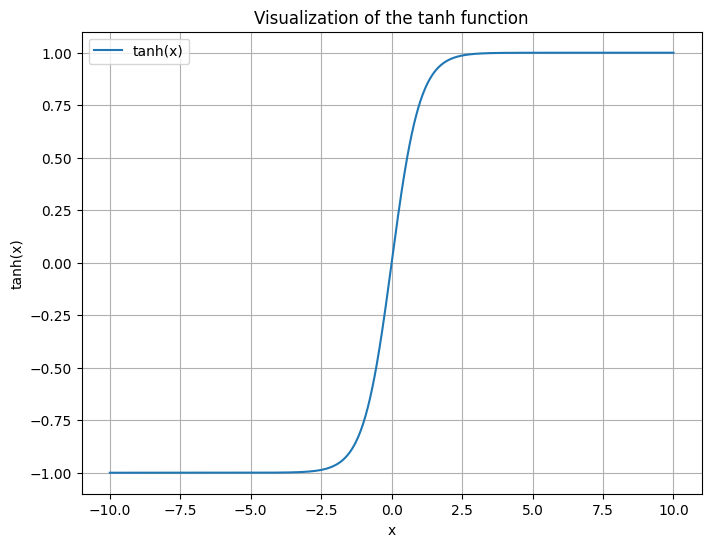

In [2]:
# Visualizing tanh function

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

x = np.linspace(-10, 10, 1000)
y = np.tanh(x)

plt.figure(figsize=(8, 6))
plt.plot(x, y, label='tanh(x)')
plt.xlabel('x')
plt.ylabel('tanh(x)')
plt.title('Visualization of the tanh function')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
#This is how to train a normal mlp and lstm on same input features, will be used to train stock data

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Define a simple dataset (replace with your actual data)
class DummyDataset(Dataset):
    def __init__(self, num_samples=1000, seq_length=10, input_dim=5):
        self.num_samples = num_samples
        self.seq_length = seq_length
        self.input_dim = input_dim
        self.data = torch.randn(num_samples, seq_length, input_dim)
        self.labels = torch.randint(0, 2, (num_samples,)) # Binary classification example

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Define a simple MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # MLP expects flattened input
        x = x.view(x.size(0), -1) # Flatten the sequence and input dimensions
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # We need to handle the case where x might be a single timestep if batch_first=True
        if x.dim() == 2:
          x = x.unsqueeze(1) # Add sequence dimension if missing

        # We need to ensure the input shape to LSTM is (batch_size, seq_length, input_dim)
        # Our dummy dataset provides this directly, but it's good practice to be aware
        # print(f"LSTM Input shape: {x.shape}") # Debugging line

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0)) # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :]) # Take the output of the last timestep
        return out

# Hyperparameters
input_dim = 5
seq_length = 10
hidden_size = 64
output_size = 2 # For binary classification
learning_rate = 0.001
num_epochs = 10
batch_size = 32

# Create dataset and dataloader
dataset = DummyDataset(seq_length=seq_length, input_dim=input_dim)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True) #torch.Size([32, 10, 5]) torch.Size([32]), 32 is batch, 10 is total sequence and 5 are features

# --- Training the MLP ---
print("--- Training MLP ---")
# Calculate the input size for the MLP after flattening
mlp_input_size = seq_length * input_dim #so in mlp we pass then entire sequence as a single vector of seq x features dimention
mlp_model = MLP(mlp_input_size, hidden_size, output_size)
criterion_mlp = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(mlp_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = mlp_model(inputs)
        loss = criterion_mlp(outputs, labels)

        # Backward and optimize
        optimizer_mlp.zero_grad()
        loss.backward()
        optimizer_mlp.step()

    print(f'MLP Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# --- Training the LSTM ---
print("\n--- Training LSTM ---")
lstm_model = LSTMModel(input_dim, hidden_size, output_size)
criterion_lstm = nn.CrossEntropyLoss()
optimizer_lstm = optim.Adam(lstm_model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    for inputs, labels in dataloader:
        # Forward pass
        outputs = lstm_model(inputs)
        loss = criterion_lstm(outputs, labels)

        # Backward and optimize
        optimizer_lstm.zero_grad()
        loss.backward()
        optimizer_lstm.step()

    print(f'LSTM Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("\nTraining complete for both models.")


--- Training MLP ---
MLP Epoch [1/10], Loss: 0.7181
MLP Epoch [2/10], Loss: 0.7400
MLP Epoch [3/10], Loss: 0.6578
MLP Epoch [4/10], Loss: 0.5704
MLP Epoch [5/10], Loss: 0.6315
MLP Epoch [6/10], Loss: 0.5003
MLP Epoch [7/10], Loss: 0.7133
MLP Epoch [8/10], Loss: 0.7028
MLP Epoch [9/10], Loss: 0.4751
MLP Epoch [10/10], Loss: 0.4757


In [ ]:
torch.zeros(1, 32, 64).to(x.device).shape

In [ ]:
for inputs, labels in dataloader:
  print(inputs.size(0))
  print(inputs.dim())

# Finance RL

In [ ]:
# prompt: give me the code to download stock price data of american stocks (10) from 2010 to 2025 everyday (ever hour if possible too)

!pip install yfinance

import yfinance as yf
import pandas as pd

In [ ]:
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA",
    "META", "JPM", "JNJ", "V", "PG"
]

start_date = "2010-01-01"
end_date = "2025-01-01"

def download_daily_data(
    tickers: list,
    start: str,
    end: str,
):
    data_all = pd.DataFrame()
    for ticker in tickers:
        try:
            df = yf.download(ticker, start=start, end=end, interval="1d")
            df.columns = ['-'.join(tup) for tup in df.columns.values]
            data_all = pd.merge(data_all, df,left_index=True,right_index=True,how='outer')
            print(f"Downloaded daily data for {ticker}")
        except Exception as e:
            print(f"Could not download daily data for {ticker}: {e}")
    return data_all

daily_stock_data = download_daily_data(tickers, start_date, end_date)


/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 comple

Downloaded daily data for AAPL
Downloaded daily data for MSFT
Downloaded daily data for GOOGL
Downloaded daily data for AMZN


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1

Downloaded daily data for TSLA
Downloaded daily data for META
Downloaded daily data for JPM
Downloaded daily data for JNJ


[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-34-1081140705.py:17: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start, end=end, interval="1d")
[*********************100%***********************]  1 of 1 completed


Downloaded daily data for V
Downloaded daily data for PG


In [ ]:
len(daily_stock_data.columns)

50